In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from functools import partial

import emmental
from data_generator import generate_data, get_circle_mask,generate_slice_labels
from emmental import Meta
from emmental.data import EmmentalDataLoader, EmmentalDataset
from emmental.learner import EmmentalLearner
from emmental.model import EmmentalModel
from emmental.scorer import Scorer
from emmental.task import EmmentalTask
from viz import visualize_dataset

In [3]:
config={"meta_config": {"seed": 444}, "learner_config": {"ignore_index": 0, "lr_scheduler_config":{"lr_scheduler":None}}}

In [4]:
emmental.init("test_run", config=config)

[2019-05-03 18:21:16,076][INFO] emmental.meta:95 - Setting logging directory to: test_run/2019_05_03/18_21_16
[2019-05-03 18:21:16,091][INFO] emmental.meta:56 - Loading Emmental default config from /Users/senwu/Desktop/folder/deleteme/test/test/test/emmental/src/emmental/emmental-default-config.yaml.
[2019-05-03 18:21:16,091][INFO] emmental.meta:143 - Updating Emmental config from user provided config.


444


In [5]:
Meta.config

{'meta_config': {'seed': 444, 'verbose': True, 'device': 0},
 'learner_config': {'fp16': False,
  'model_path': None,
  'n_epochs': 1,
  'train_split': 'train',
  'valid_split': 'valid',
  'test_split': 'test',
  'ignore_index': 0,
  'optimizer_config': {'optimizer': 'sgd',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': 1.0,
   'sgd_config': {'momentum': 0.9},
   'adam_config': {'betas': (0.9, 0.999)}},
  'lr_scheduler_config': {'lr_scheduler': None,
   'warmup_steps': 0,
   'warmup_unit': 'batch',
   'min_lr': 0.0,
   'linear_config': {'min_lr': 0.0},
   'exponential_config': {'gamma': 0.9},
   'plateau_config': {'factor': 0.5, 'patience': 10, 'threshold': 0.0001}},
  'task_scheduler': 'round_robin'},
 'logging_config': {'counter_unit': 'batch',
  'evaluation_freq': 2,
  'writer_config': {'writer': 'tensorboard', 'verbose': True},
  'checkpointing': True,
  'checkpointer_config': {'checkpoint_path': None,
   'checkpoint_freq': 1,
   'checkpoint_metric': 'model/train/all/loss',
   'chec

In [6]:
logger = logging.getLogger(__name__)

In [7]:
logger.info(f"Seed {Meta.config['meta_config']['seed']}")

[2019-05-03 18:21:16,190][INFO] __main__:1 - Seed 444


### Generate Synthetic Dataset

We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$. We define this slice as our *critical_region*.

In [8]:
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval dataset over the *critical_slice*

In [9]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [10]:
slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder, 'all': identity_fn}

In [11]:
split = 0
split_data = [torch.Tensor(x) for x in Xs[split]]
split_labels = {
    label_name: torch.LongTensor(label_value)
    for label_name, label_value in generate_slice_labels(
        Xs[split], Ys[split], slice_funcs, create_ind=False, create_preds=True
    ).items()
}

train_dataset = EmmentalDataset(
    name="synthetic",
    X_dict={"data": split_data, "uid": uid_lists[split]},
    Y_dict=split_labels,
)

split = 1
split_data = [torch.Tensor(x) for x in Xs[split]]
split_labels = {
    label_name: torch.LongTensor(label_value)
    for label_name, label_value in generate_slice_labels(
        Xs[split], Ys[split], slice_funcs, create_ind=False, create_preds=True
    ).items()
}
dev_dataset = EmmentalDataset(
    name="synthetic",
    X_dict={"data": split_data, "uid": uid_lists[split]},
    Y_dict=split_labels,
)

split = 2
split_data = [torch.Tensor(x) for x in Xs[split]]
split_labels = {
    label_name: torch.LongTensor(label_value)
    for label_name, label_value in generate_slice_labels(
        Xs[split], Ys[split], slice_funcs, create_ind=False, create_preds=True
    ).items()
}
test_dataset = EmmentalDataset(
    name="synthetic",
    X_dict={"data": split_data, "uid": uid_lists[split]},
    Y_dict=split_labels,
)

Vizualizing slice_1 from synthetic


/Users/senwu/.venv/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


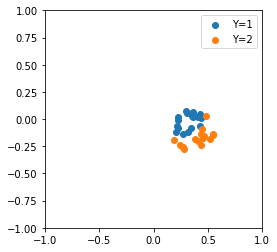

Vizualizing slice_2 from synthetic


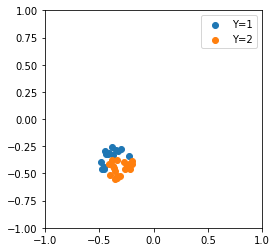

Vizualizing remainder from synthetic


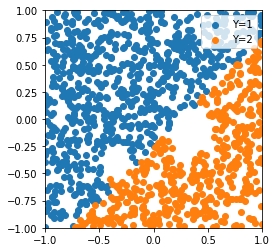

Vizualizing all from synthetic


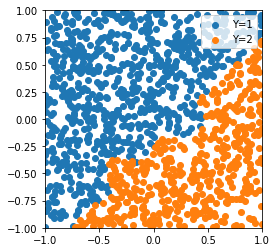

In [12]:
visualize_dataset(test_dataset)

### Generate dataloader

In [13]:
batch_size = 1

In [14]:
task_to_label_dict = {"all": "all", "slice_1": "slice_1", "slice_2": "slice_2"}

train_dataloader = EmmentalDataLoader(
    task_to_label_dict=task_to_label_dict,
    dataset=train_dataset,
    split="train",
    batch_size=batch_size,
)
dev_dataloader = EmmentalDataLoader(
    task_to_label_dict=task_to_label_dict,
    dataset=dev_dataset,
    split="valid",
    batch_size=batch_size,
)
test_dataloader = EmmentalDataLoader(
    task_to_label_dict=task_to_label_dict,
    dataset=test_dataset,
    split="test",
    batch_size=batch_size,
)

### Create tasks

In [15]:
def ce_loss(task_name, immediate_ouput_dict, Y, active):
    module_name = f"{task_name}_pred_head"
#     print(immediate_ouput_dict)
#     print(Y)
#     print(active)
    return F.cross_entropy(
        immediate_ouput_dict[module_name][0][active],
        (Y.view(-1) - 1)[active],
    )

In [16]:
def output(task_name, immediate_ouput_dict):
    module_name = f"{task_name}_pred_head"
    return F.softmax(immediate_ouput_dict[module_name][0], dim=1)

In [17]:
tasks = [
    EmmentalTask(
        name=task_name,
        module_pool=nn.ModuleDict(
            {"input_module": nn.Sequential(nn.Linear(2, 5), nn.ReLU()), f"{task_name}_pred_head": nn.Linear(5, 2)}
        ),
        task_flow=[
            {
                "name": "input",
                "module": "input_module",
                "inputs": [("_input_", "data")],
            },
            {
                "name": f"{task_name}_pred_head",
                "module": f"{task_name}_pred_head",
                "inputs": [("input", 0)],
            },
        ],
        loss_func=partial(ce_loss, task_name),
        output_func=partial(output, task_name),
        scorer=Scorer(metrics=["accuracy"]),
    )
    for task_name in task_to_label_dict.keys()
]

[2019-05-03 18:21:18,259][INFO] emmental.task:34 - Created task: all
[2019-05-03 18:21:18,260][INFO] emmental.task:34 - Created task: slice_1
[2019-05-03 18:21:18,262][INFO] emmental.task:34 - Created task: slice_2


In [18]:
mtl_model = EmmentalModel(name = 'all', tasks=tasks)

[2019-05-03 18:21:18,287][INFO] emmental.model:64 - No cuda device available. Switch to cpu instead.
[2019-05-03 18:21:18,287][INFO] emmental.model:64 - No cuda device available. Switch to cpu instead.
[2019-05-03 18:21:18,288][INFO] emmental.model:64 - No cuda device available. Switch to cpu instead.
[2019-05-03 18:21:18,289][INFO] emmental.model:44 - Created emmental model all that contains task {'slice_2', 'slice_1', 'all'}.
[2019-05-03 18:21:18,290][INFO] emmental.model:64 - No cuda device available. Switch to cpu instead.


In [19]:
emmental_learner = EmmentalLearner()

In [20]:
Meta.update_config(
    config={
        "learner_config": {"n_epochs": 500, "optimizer_config": {"lr": 0.01}},
        "logging_config": {
            "evaluation_freq": 5,
            "counter_unit": "epoch",
            "checkpointing": False,
        },
    }
)

[2019-05-03 18:21:18,338][INFO] emmental.meta:143 - Updating Emmental config from user provided config.


In [21]:
emmental_learner.learn(mtl_model, [train_dataloader, dev_dataloader])

[2019-05-03 18:21:18,361][INFO] emmental.logging.logging_manager:33 - Evaluating every 5 epoch.
[2019-05-03 18:21:18,362][INFO] emmental.logging.logging_manager:51 - No checkpointing.
[2019-05-03 18:21:18,421][INFO] root:31 - Failed to import cuda module: No module named 'caffe2.python.caffe2_pybind11_state_gpu'
[2019-05-03 18:21:18,422][INFO] root:38 - Failed to import AMD hip module: No module named 'caffe2.python.caffe2_pybind11_state_hip'
[2019-05-03 18:21:18,423][WARNING] root:41 - This caffe2 python run does not have GPU support. Will run in CPU only mode.
[2019-05-03 18:21:18,431][INFO] emmental.learner:283 - Start learning...


In [22]:
mtl_model.score(test_dataloader)

{'all/synthetic/test/accuracy': 0.9664,
 'slice_1/synthetic/test/accuracy': 0.9705882352941176,
 'slice_2/synthetic/test/accuracy': 0.90625}

In [23]:
mtl_model.score(dev_dataloader)

{'all/synthetic/valid/accuracy': 0.9728,
 'slice_1/synthetic/valid/accuracy': 0.9024390243902439,
 'slice_2/synthetic/valid/accuracy': 0.8571428571428571}

In [24]:
mtl_model.score(test_dataloader)

{'all/synthetic/test/accuracy': 0.9664,
 'slice_1/synthetic/test/accuracy': 0.9705882352941176,
 'slice_2/synthetic/test/accuracy': 0.90625}

In [25]:
gold_dict, prob_dict, pred_dict = mtl_model.predict(dev_dataloader, return_preds=True)

In [26]:
gold_dict

defaultdict(list,
            {'all': array([1, 2, 2, ..., 1, 1, 2]),
             'slice_1': array([1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1,
                    2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2]),
             'slice_2': array([2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1,
                    2, 1, 1, 1, 2, 1])})

In [27]:
len(gold_dict['slice_2'])

28

In [28]:
gold_dict['slice_2']

array([2, 2, 1, 2, 2, 1, 2, 2, 1, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 1,
       2, 1, 1, 1, 2, 1])

In [29]:
pred_dict['slice_2']

array([1, 2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 1])

In [30]:
from emmental.metrics.accuracy import accuracy_scorer

accuracy_scorer(gold_dict['slice_2'], pred_dict['slice_2'], pred_dict['slice_2'])

{'accuracy': 0.8571428571428571}

In [31]:
sum(dev_dataset.Y_dict["slice_2"].numpy() != 0)

28